# Plot Q densities with average Q density

Qs overall

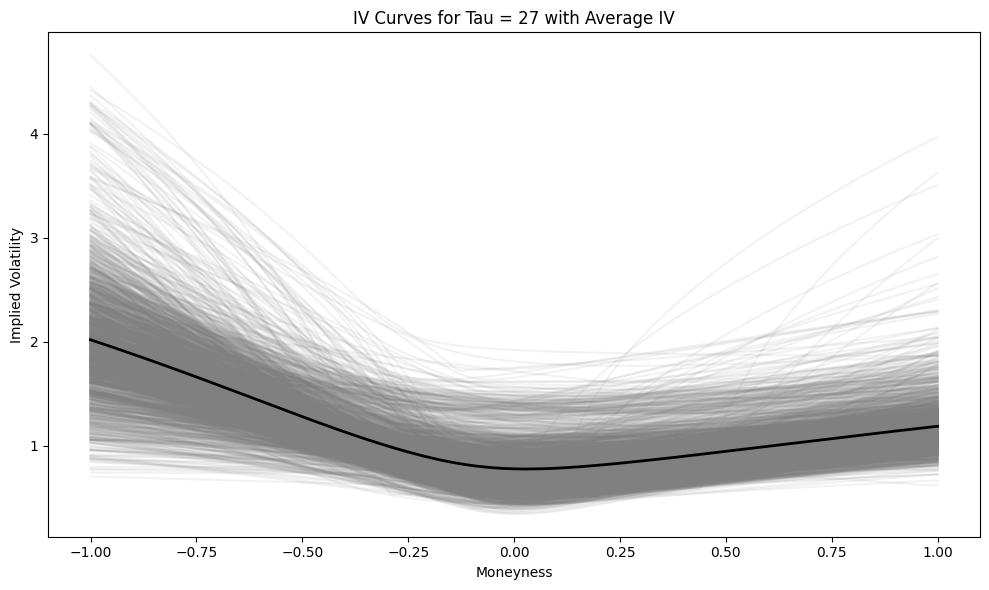

In [ ]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Directory with the interpolated IV files
interpolated_iv_path = "IV/IV_surface_SVI/Tau-independent/unique/moneyness_step_0d01/"
files = sorted(glob.glob(os.path.join(interpolated_iv_path, "interpolated_*_allR2.csv")))
plot_to_save_path = "IV/IV_curve_SVI_average_plot/Tau-independent/unique/moneyness_step_0d01/"
os.makedirs(plot_to_save_path, exist_ok=True)

plt.figure(figsize=(10, 6))

# Lists to store all IV curves and corresponding moneyness values
all_iv_curves = []
common_moneyness = None

for file in files:
    df = pd.read_csv(file)
    # Filter the DataFrame to only include rows where TTM == 27
    df_tau = df[df["TTM"] == 27]
    if df_tau.empty:
        continue
    
    # There should be one row per file with TTM == 27
    row = df_tau.iloc[0]
    
    # Extract IV values by dropping the "Date" and "TTM" columns
    iv_values = row.drop(labels=["Date", "TTM"])
    
    # Convert the remaining column names (assumed moneyness) to floats
    try:
        moneyness = np.array([float(col) for col in iv_values.index])
    except ValueError:
        moneyness = iv_values.index.astype(float)
    
    iv = iv_values.values.astype(float)
    
    # Sort by moneyness in case columns are not in order
    sort_idx = np.argsort(moneyness)
    moneyness = moneyness[sort_idx]
    iv = iv[sort_idx]
    
    # Plot individual IV curve in gray
    date_label = row["Date"]
    plt.plot(moneyness, iv, label=date_label, alpha=0.1, color="gray")
    
    # Store the IV curve for averaging if it doesn't contain NaNs, othersie print the date
    if np.isnan(iv).any():
        print(f"NaN values found in IV curve for {date_label}")
    else:
        all_iv_curves.append(iv)
    if common_moneyness is None:
        common_moneyness = moneyness

# Compute and plot the average IV curve if any curves were found
if all_iv_curves:
    avg_iv = np.nanmean(all_iv_curves, axis=0)
    plt.plot(common_moneyness, avg_iv, color="black", linewidth=2, label="Average IV")

plt.xlabel("Moneyness")
plt.ylabel("Implied Volatility")
plt.title("IV Curves for Tau = 27 with Average IV")
plt.grid(False)
plt.tight_layout()
plt.savefig(os.path.join(plot_to_save_path, "IV_curve_SVI_overall_average_Tau-independent_unique_moneyness_step_0d01_TTM_27.png"))
plt.show()

By each cluster

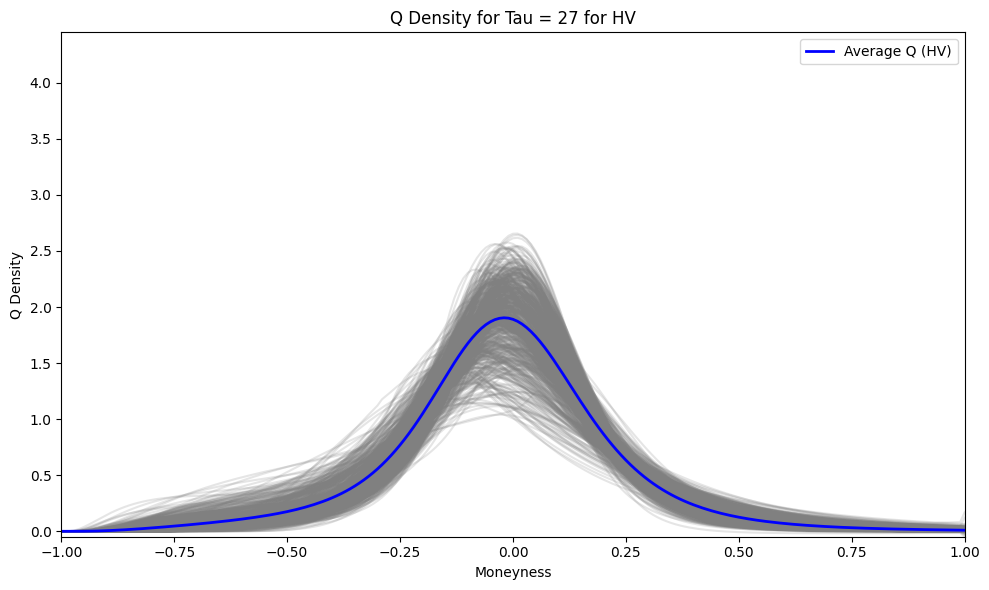

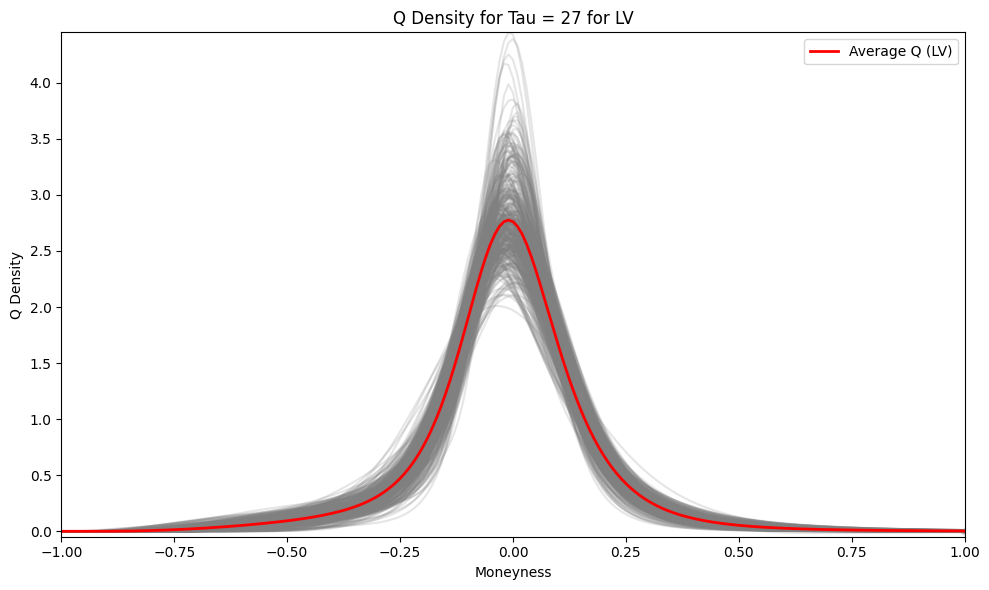

In [3]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

work_path = "/Users/irtg/Documents/Github/BTC-premia/SVI_independent_tau/"
os.chdir(work_path)

# Load cluster dates
common_dates = pd.read_csv(os.path.join('Clustering', 'Tau-independent', 'unique', 'moneyness_step_0d01', 
                                          'multivariate_clustering_9_27_45', 'common_dates_cluster.csv'))
dates_Q = {
    0: common_dates[common_dates["Cluster"] == 0]["Date"].astype(str).tolist(),
    1: common_dates[common_dates["Cluster"] == 1]["Date"].astype(str).tolist()
}

# Define cluster names and colors: Cluster 0 -> HV (blue), Cluster 1 -> LV (red)
cluster_names = {0: "HV", 1: "LV"}
cluster_colors = {0: "blue", 1: "red"}

# Choose the TTM to plot (for example, 27 days)
ttm_to_plot = 27

# Base output path from Q density estimation (adjust if needed)
q_dir = os.path.join(work_path, "Q_from_pure_SVI", "Tau-independent", "unique", "moneyness_step_0d01", f"tau_{ttm_to_plot}")

# Folder to save the plots
plot_to_save_path = os.path.join(work_path, "Q_plots", "Tau-independent", "unique", "moneyness_step_0d01", "Q_density_average_plot", f"tau_{ttm_to_plot}", "multivariate_clustering_9_27_45") 
os.makedirs(plot_to_save_path, exist_ok=True)

# List Q density CSV files in the chosen TTM folder
q_files = sorted([f for f in os.listdir(q_dir) if f.endswith(".csv")])

# Dictionaries to store Q density curves and corresponding moneyness arrays by cluster
cluster_q_curves = {0: [], 1: []}
cluster_common_moneyness = {0: None, 1: None}

for file in q_files:
    # Assuming file naming pattern "btc_Q_{date}.csv"
    parts = file.split('_')
    if len(parts) < 3:
        continue
    date_str = parts[2].replace(".csv", "")
    
    # Determine cluster membership
    if date_str in dates_Q[0]:
        cluster = 0
    elif date_str in dates_Q[1]:
        cluster = 1
    else:
        # Date not found in any cluster; skip this file
        continue
    
    file_path = os.path.join(q_dir, file)
    df_q = pd.read_csv(file_path)
    
    # Check that required columns are present
    if 'm' not in df_q.columns or 'spdy' not in df_q.columns:
        continue
    
    # Get moneyness and Q density values
    m_vals = df_q['m'].values
    q_density = df_q['spdy'].values
    
    # Ensure the values are sorted by moneyness
    sort_idx = np.argsort(m_vals)
    m_vals = m_vals[sort_idx]
    q_density = q_density[sort_idx]
    
    # Save the density curve
    cluster_q_curves[cluster].append(q_density)
    
    # Save common moneyness (assumed same for all files in the cluster)
    if cluster_common_moneyness[cluster] is None:
        cluster_common_moneyness[cluster] = m_vals

# Unify axis ranges across clusters
all_m_vals = []
for cl in [0, 1]:
    if cluster_common_moneyness[cl] is not None:
        all_m_vals.append(cluster_common_moneyness[cl])
if all_m_vals:
    all_m_vals = np.concatenate(all_m_vals)
    x_min, x_max = np.min(all_m_vals), np.max(all_m_vals)
else:
    x_min, x_max = 0, 1

all_q_values = []
for cl in [0, 1]:
    for q in cluster_q_curves[cl]:
        all_q_values.append(q)
if all_q_values:
    all_q_values = np.concatenate(all_q_values)
    y_min, y_max = np.min(all_q_values), np.max(all_q_values)
else:
    y_min, y_max = 0, 1

# Create separate plots for each cluster
for cluster in [0, 1]:
    plt.figure(figsize=(10, 6))
    
    # Plot all individual Q density curves in gray
    for q in cluster_q_curves[cluster]:
        plt.plot(cluster_common_moneyness[cluster], q, color="gray", alpha=0.2)
    
    # Compute and plot the average Q density curve in the cluster's designated color
    if cluster_q_curves[cluster]:
        avg_q = np.nanmean(cluster_q_curves[cluster], axis=0)
        plt.plot(cluster_common_moneyness[cluster], avg_q, color=cluster_colors[cluster], 
                 linewidth=2, label=f"Average Q ({cluster_names[cluster]})")
    
    plt.xlabel("Moneyness")
    plt.ylabel("Q Density")
    plt.title(f"Q Density for Tau = {ttm_to_plot} for {cluster_names[cluster]}")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc="best")
    plt.grid(False)
    plt.tight_layout()
    
    # Save the plot to file
    out_file = os.path.join(plot_to_save_path, f"Q_density_tau_{ttm_to_plot}_{cluster_names[cluster]}.png")
    plt.savefig(out_file)
    plt.show()

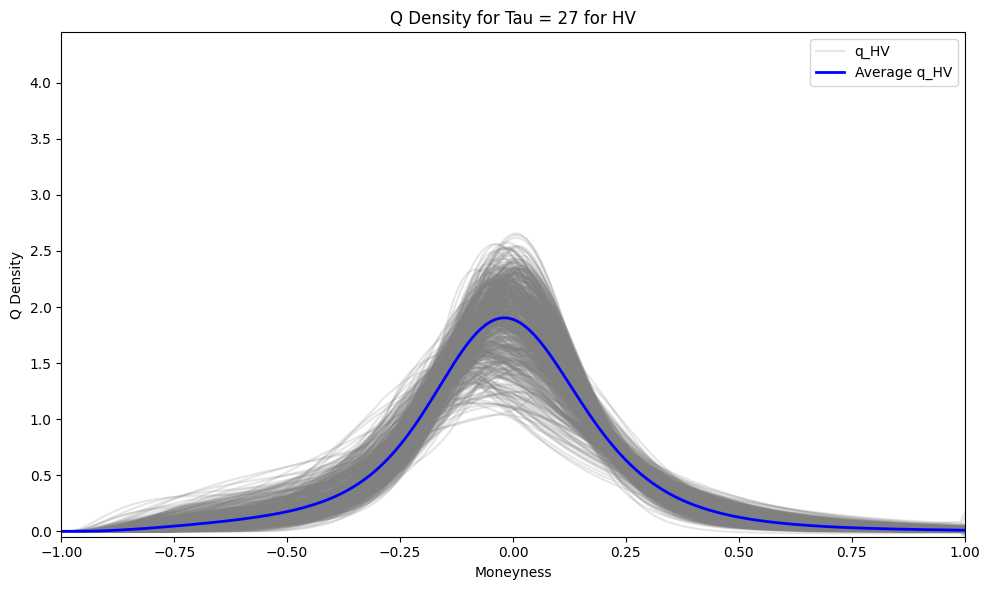

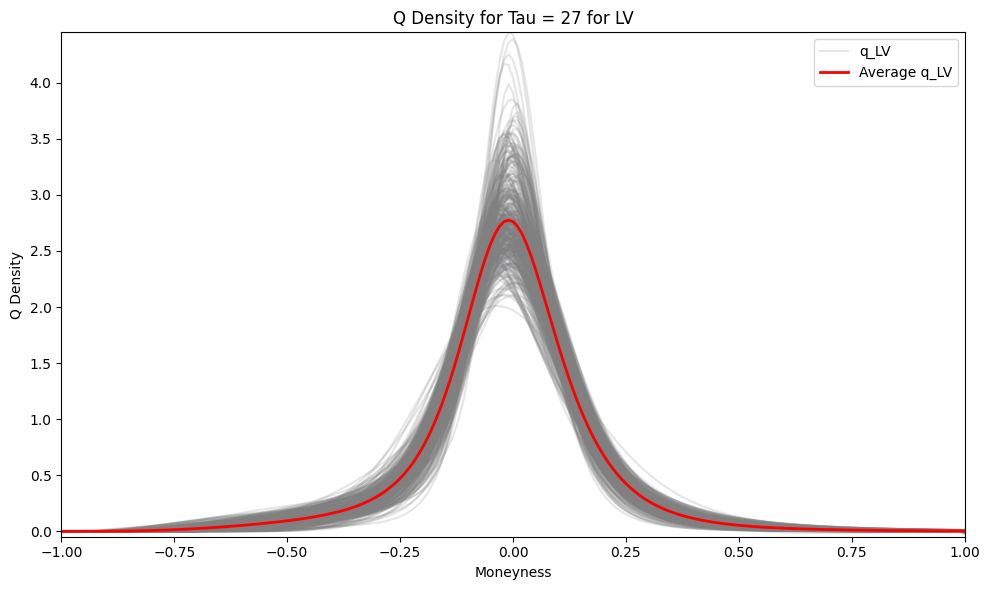

In [4]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

work_path = "/Users/irtg/Documents/Github/BTC-premia/SVI_independent_tau/"
os.chdir(work_path)

# Load cluster dates
common_dates = pd.read_csv(os.path.join('Clustering', 'Tau-independent', 'unique', 'moneyness_step_0d01', 
                                          'multivariate_clustering_9_27_45', 'common_dates_cluster.csv'))
dates_Q = {
    0: common_dates[common_dates["Cluster"] == 0]["Date"].astype(str).tolist(),
    1: common_dates[common_dates["Cluster"] == 1]["Date"].astype(str).tolist()
}

# Define cluster names and colors: Cluster 0 -> HV (blue), Cluster 1 -> LV (red)
cluster_names = {0: "HV", 1: "LV"}
cluster_colors = {0: "blue", 1: "red"}

# Choose the TTM to plot (for example, 27 days)
ttm_to_plot = 27

# Base output path from Q density estimation (adjust if needed)
q_dir = os.path.join(work_path, "Q_from_pure_SVI", "Tau-independent", "unique", "moneyness_step_0d01", f"tau_{ttm_to_plot}")

# Folder to save the plots
plot_to_save_path = os.path.join(work_path, "Q_plots", "Tau-independent", "unique", "moneyness_step_0d01", "Q_density_average_plot", f"tau_{ttm_to_plot}", "multivariate_clustering_9_27_45") 
os.makedirs(plot_to_save_path, exist_ok=True)

# List Q density CSV files in the chosen TTM folder
q_files = sorted([f for f in os.listdir(q_dir) if f.endswith(".csv")])

# Dictionaries to store Q density curves and corresponding moneyness arrays by cluster
cluster_q_curves = {0: [], 1: []}
cluster_common_moneyness = {0: None, 1: None}

for file in q_files:
    # Assuming file naming pattern "btc_Q_{date}.csv"
    parts = file.split('_')
    if len(parts) < 3:
        continue
    date_str = parts[2].replace(".csv", "")
    
    # Determine cluster membership
    if date_str in dates_Q[0]:
        cluster = 0
    elif date_str in dates_Q[1]:
        cluster = 1
    else:
        # Date not found in any cluster; skip this file
        continue
    
    file_path = os.path.join(q_dir, file)
    df_q = pd.read_csv(file_path)
    
    # Check that required columns are present
    if 'm' not in df_q.columns or 'spdy' not in df_q.columns:
        continue
    
    # Get moneyness and Q density values
    m_vals = df_q['m'].values
    q_density = df_q['spdy'].values
    
    # Ensure the values are sorted by moneyness
    sort_idx = np.argsort(m_vals)
    m_vals = m_vals[sort_idx]
    q_density = q_density[sort_idx]
    
    # Save the density curve
    cluster_q_curves[cluster].append(q_density)
    
    # Save common moneyness (assumed same for all files in the cluster)
    if cluster_common_moneyness[cluster] is None:
        cluster_common_moneyness[cluster] = m_vals

# Unify axis ranges across clusters
all_m_vals = []
for cl in [0, 1]:
    if cluster_common_moneyness[cl] is not None:
        all_m_vals.append(cluster_common_moneyness[cl])
if all_m_vals:
    all_m_vals = np.concatenate(all_m_vals)
    x_min, x_max = np.min(all_m_vals), np.max(all_m_vals)
else:
    x_min, x_max = 0, 1

all_q_values = []
for cl in [0, 1]:
    for q in cluster_q_curves[cl]:
        all_q_values.append(q)
if all_q_values:
    all_q_values = np.concatenate(all_q_values)
    y_min, y_max = np.min(all_q_values), np.max(all_q_values)
else:
    y_min, y_max = 0, 1

# Create separate plots for each cluster
for cluster in [0, 1]:
    plt.figure(figsize=(10, 6))
    
    # Plot all individual Q density curves in gray
    for q in cluster_q_curves[cluster]:
        plt.plot(cluster_common_moneyness[cluster], q, color="gray", alpha=0.2)
    
    # Add a dummy plot to include the individual Q densities in the legend
    plt.plot([], [], color="gray", alpha=0.2, label=f"q_{cluster_names[cluster]}")
    
    # Compute and plot the average Q density curve in the cluster's designated color
    if cluster_q_curves[cluster]:
        avg_q = np.nanmean(cluster_q_curves[cluster], axis=0)
        plt.plot(cluster_common_moneyness[cluster], avg_q, color=cluster_colors[cluster], 
                 linewidth=2, label=f"Average q_{cluster_names[cluster]}")
    
    plt.xlabel("Moneyness")
    plt.ylabel("Q Density")
    plt.title(f"Q Density for Tau = {ttm_to_plot} for {cluster_names[cluster]}")
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.legend(loc="best")
    plt.grid(False)
    plt.tight_layout()
    
    # Save the plot to file
    out_file = os.path.join(plot_to_save_path, f"Q_density_tau_{ttm_to_plot}_{cluster_names[cluster]}.png")
    plt.savefig(out_file)
    plt.show()